In [29]:
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
import math

# this system

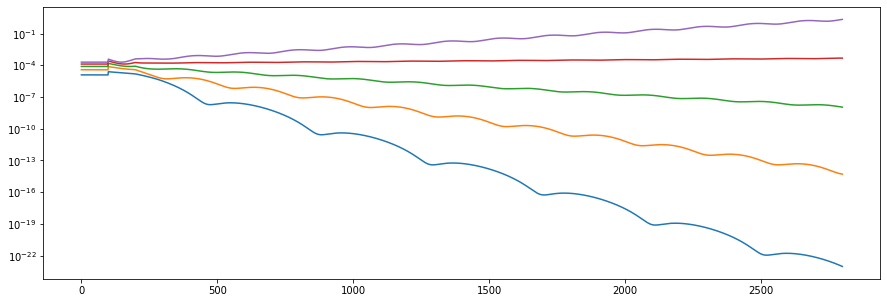

In [115]:
x_0 = 1
dt = 1e-3
tau = 0.1

size = 3000

plt.figure(figsize=(15,5))
for k in torch.linspace(5,20,5):
    tau_idxs = int(tau/dt)
    x = torch.empty(size)
    x[:tau_idxs] = 0
    x[tau_idxs] = 1e-3
    time = [i*dt for i in range(len(x))]

    for i in range(tau_idxs+1,len(x)):
        dx = - k * x[i-tau_idxs]
        x[i] = x[i-1] + dt*dx

    x_diff = torch.empty(3000)
    x_diff[:-1] = x.diff()/dt
    x_diff[-1] = x_diff[-2]
    x_diff_embed = torch.stack([x_diff[i:i+tau_idxs] for i in range(len(x_diff)-tau_idxs)])

    # plt.scatter(time,x,marker='.', c=time)
    # plt.ylim(-1.5e-3,1.5e-3)
    # plt.figure()
    # emb_tau = 100
    # plt.scatter(x[emb_tau:],x[:-emb_tau], marker='.', c=time[:-emb_tau])
    # plt.ylim(-1.5e-3,1.5e-3)
    # plt.xlim(-1.5e-3,1.5e-3)

    #plt.figure(figsize=(15,5))
    #m = 1
    #E = 1/2*m*(x.diff()/dt)**2 + 1/2* k *x[:-1]**2
    #E_ = 1/2*m*(x[tau_idxs:].diff()/dt)**2 +1/2* k *x[:-(1+tau_idxs)]**2

    #E_g = 1/2*(x_diff_embed**2 ).mean(dim=1)
    E_e = 1/2*(x_diff[:-tau_idxs-1]**2+x_diff[1+tau_idxs:]**2)

    plt.plot(E_e[tau_idxs:])
plt.yscale('log')
    #plt.plot(E, c= 'grey')
    #plt.plot(E_,c='blue')
    #plt.ylim(1e-5,5e-4)

In [52]:
x[tau_idxs:].diff().shape

torch.Size([2899])

In [9]:
x[:-(1+tau_idxs)].shape

torch.Size([899])

# "Conservative" system

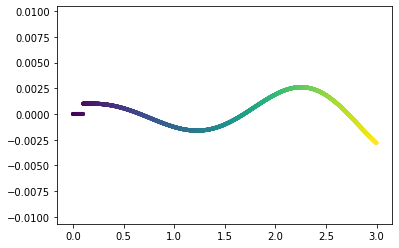

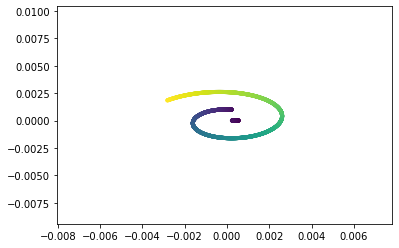

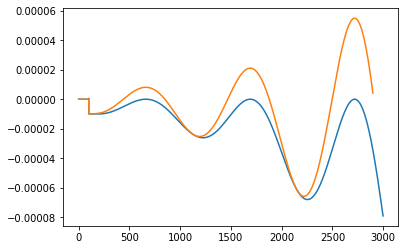

In [24]:
x_0 = 1
dt = 1e-3
tau = 0.1
k = 10
size = 3000

tau_idxs = int(tau/dt)
x = torch.empty(size)
dx = torch.zeros(size)
x[:tau_idxs] = 0
x[tau_idxs] = 1e-3
time = [i*dt for i in range(len(x))]

for i in range(tau_idxs+1,len(x)):
    ddx = - k * x[i-tau_idxs]
    dx[i] = dx[i-1] + dt*ddx
    x[i] = x[i-1] + dt*dx[i]

plt.scatter(time,x,marker='.', c=time)
#plt.ylim(-1.5e-3,1.5e-3)
plt.figure()
emb_tau = 500
plt.scatter(x[emb_tau:],x[:-emb_tau], marker='.', c=time[:-emb_tau])
#plt.ylim(-1.5e-3,1.5e-3)
#plt.xlim(-1.5e-3,1.5e-3)

E = 1/2*x.diff()**2 - k *x[:-1]**2
E_ = 1/2*(x[tau_idxs:].diff()/dt)**2 - k *x[:-(1+tau_idxs)]**2
plt.figure()
plt.plot(E)
plt.plot(E_)

# Neural net

In [28]:
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
import math

In [29]:
# create training data

In [30]:
dt = 1e-3
tau = 0# 0.1
num = 20
size = 3000
x = torch.empty((num,size))
dx = torch.zeros((num,size))
time = [i*dt for i in range(len(x[0]))]
ks = torch.linspace(5,15,num)
tau_idxs = int(tau/dt)
for i,k in enumerate(ks):
    x[i,:tau_idxs+1] = 1e-3
    for j in range(tau_idxs+1,len(x[i])):
        dx[i,j] = - k * x[i][j-tau_idxs-1]
        x[i,j] = x[i,j-1] + dt*dx[i,j]
x = x*5000
dx = dx*1000

In [31]:
x.mean(), x.std(), dx.mean(), dx.std()

(tensor(0.1852), tensor(0.6563), tensor(-0.3333), tensor(1.2509))

In [32]:
class lambda_tracker():
    def __init__(self):
        self.data = defaultdict(lambda:{"size":0,"value":0})
        
    def get_error_and_update(self,k,value):
        error = (self.data[k]['value']-value)**2
        self.data[k]['value'] = (self.data[k]['size']*self.data[k]['value']+value)/(self.data[k]['size']+1)
        self.data[k]['size'] += 1
        return error
        

    

In [33]:
def get_train_and_target(num_data = 1000):
    train_data = torch.empty((num_data,2*(tau_idxs+1)))
    target_data = torch.empty((num_data,2))
    for trial,j,i in zip(range(num_data),torch.randint(num,(num_data,)),torch.randint(tau_idxs,size-tau_idxs,(num_data,))):
        train_data[trial] = torch.concat((x[j,i:i+tau_idxs+1],dx[j,i:i+tau_idxs+1]))
        target_data[trial] = torch.tensor([ks[j],i*dt])
    return train_data, target_data

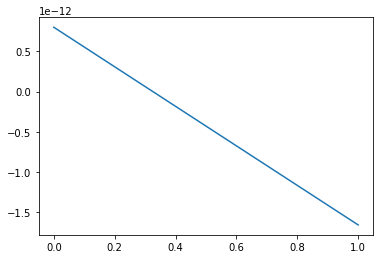

In [34]:
train_data, target_data = get_train_and_target()
plt.plot(train_data[0])

In [71]:
import torch.nn as nn
import torch.optim as optim


class Net(nn.Module):

    def __init__(self, insize):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(insize, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 5)
        self.fc4 = nn.Linear(5, 2)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = self.fc4(x)
        return x


net = Net(2)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=5, bias=True)
  (fc4): Linear(in_features=5, out_features=2, bias=True)
)


In [72]:
# learning_rate = 0.01
# for f in net.parameters():
#     f.data.sub_(f.grad.data * learning_rate)

In [81]:
# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.05)

# in your training loop:
loss_history = []
my_lambda_tracker = lambda_tracker()
for i in range(2000):
    train_data, target_data = get_train_and_target()
    optimizer.zero_grad()   # zero the gradient buffers
    

    output = net(train_data)
    #la_errors = torch.empty(len(output))
    #for i,la,k in zip(range(len(output)),output[:,1],target_data[:,0]):
    #    la_errors[i] = my_lambda_tracker.get_error_and_update(k.item(),la.item())
    #target = target.view(1, -1)  # make it the same shape as output
    criterion1 = nn.MSELoss()

    loss = criterion1(output, target_data) #+ criterion1(output[:,1], target_data[:,1])
    loss_history.append(loss)
    loss.backward()
    optimizer.step()    # Does the update

tensor(4.8277, grad_fn=<MseLossBackward0>)


(0, 10)

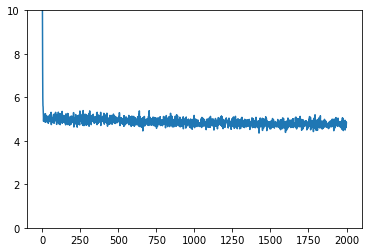

In [84]:
plt.plot(loss_history)
print(loss_history[-1])
plt.ylim(0,10)

In [85]:
train_data, target_data = get_train_and_target()

In [86]:
net(train_data[:3]),target_data[:3]

(tensor([[ 9.0845,  0.1340],
         [10.0988,  1.6634],
         [10.1138,  1.6848]], grad_fn=<AddmmBackward0>),
 tensor([[ 6.0526,  0.1810],
         [ 8.1579,  0.8620],
         [10.7895,  2.0420]]))

In [88]:
target_data.var()

tensor(23.4651)